# Autograd, optimizare

Bibliografie:
1. Deep Learning with PyTorch, Eli Stevens, Luca Antiga, Thomas Viehmann, Manning; 1st edition (August 4, 2020)
1. PyTorch Pocket Reference: Building and Deploying Deep Learning Models, by Joe Papa, O'Reilly Media; 1st edition (June 1, 2021)

In [26]:
import torch
print(f'Versiune torch: {torch.__version__}')

Versiune torch: 2.0.0+cu118


In [27]:
torch.cuda.is_available()

True

## Calcul de gradienti cu autograd

Calculul derivatelor partiale ale unei functii este crucial pentru algoritmii actuali de machine learning. Modificand ponderile (parametrii, coeficientii) unei functii, se poate face printr-un proces iterativ aducerea functiei intr-o zona in care gradientii sa fie 0.

### Exemplul 1: functie de o singura variabila

In [28]:
# definim o variabila x. Pentru ca se va calcula derivata unei funcii in raport cu x, trebuie sa specificam 
# faptul ca trebuie considerat x pentru calcul de gradient
x = torch.tensor(10.0, requires_grad = True)
print(x)
# x trebuie dat ca valoare floating point; 
# o valoare initiala data ca intreg (10) face ca tensorul sa aiba datatype intreg. 
# In PyTorch gradientii se pot calcula numai pentru cantitati floating point

tensor(10., requires_grad=True)


Verificam daca tensorul x are gradient definit in acest moment:

In [29]:
x.grad is None

True

Definim o expresie care depinde de $x$, de exemplu
$$
y = 5x^3 -x^2 + 2*x -100
$$
Derivata lui $y$ in functie de $x$ este
$$
\frac{dy}{dx} = 15x^2-2x+2
$$
care evaluata pentru $x = 10$ da rezultatul 1482.

In [30]:
y = 5*x**3 - x ** 2 + 2*x - 100
# declansam calculul de gradient. Metoda backward() poate fi chemata pentru un tensor Pytorch 
y.backward()

Din acest moment, tensorul x are gradient, calculat de metoda `backward`:

In [31]:
# verificam daca s-a calculat un gradient pentru x, corespunzator lui dy/dx:
print(f'Avem gradient pe x: {x.grad is not None}')

Avem gradient pe x: True


In [32]:
# recuperam gradientul:
print(x.grad)


tensor(1482.)


**Important!** Daca mai apelam odata backward() pe o expresie care il foloseste pe x (de exemplu: aceeasi expresie y ca mai sus), atunci se calculeaza din nou gradient pentru vectorul x si se acumuleaza la cel calculat deja. Ca atare, pentru acelasi y noul gradient este 1482 + 1482 = 2964:

In [33]:
y = 5*x**3 - x ** 2 + 2*x - 100
y.backward()
x.grad

tensor(2964.)

### Exemplul 2: functie de 2 variabile

Consideram functia:
$$
z(x, y) = x^2 + y^5 - x^2\cdot y
$$
Derivatele partiale sunt:
$$
\frac{\partial z}{\partial x} = 2x-2xy
$$
respectiv
$$
\frac{\partial z}{\partial y} = 5y^4-x^2
$$

Pentru $x=3, y=4$ cele doua derivate partiale au valorile:
$$
\frac{\partial z}{\partial x}(x, y) = -18
$$
si respectiv
$$
\frac{\partial z}{\partial y}(x, y) = 1271
$$

In [34]:
x=torch.tensor(3.0, requires_grad=True)  
y=torch.tensor(4.0, requires_grad=True) 
z=x**2+y**5-x**2*y  
z.backward()  

In [35]:
# recuparam gradientii dz/dx, dz/dy
print(f'gradient dupa x={x.grad}\ngradient dupa y={y.grad}')

gradient dupa x=-18.0
gradient dupa y=1271.0


### Exemplul 3: functie de eroare patratica, mai multe ponderi instruibile

In PyTorch se pot calculaautomat gradientii chiar daca sunt folositi in interiorul unor functii definite de utilizator.

In [36]:
def f(w: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    return x.dot(w)

def error_function(y: torch.Tensor, y_hat: torch.Tensor) -> torch.Tensor:
    return (y - y_hat) ** 2

# x: valori de intrare
x = torch.tensor([1.0, 4.0, -3.0, 5.0, 4.0])
print(f'Verificam daca tensorul x e pregatit sa aiba gradient calculat: {x.requires_grad}')
# w: ponderi
w = torch.rand_like(x, requires_grad=True)

ground_truth = 10

# eroare patratica medie
error = error_function(ground_truth, f(w, x))
print(f'Eroare de predictie: error={error}')

# se calculeaza gradientii de catre Pytorch
error.backward()
print(f'Gradientii pentru w: {w.grad}')

print(f'Gradientii pentru x nu se calculeaza, deoarece tensorul x are requires_grad=False')
print(f'\tx.grad is None={x.grad is None}')

Verificam daca tensorul x e pregatit sa aiba gradient calculat: False
Eroare de predictie: error=18.102209091186523
Gradientii pentru w: tensor([ -8.5093, -34.0374,  25.5280, -42.5467, -34.0374])
Gradientii pentru x nu se calculeaza, deoarece tensorul x are requires_grad=False
	x.grad is None=True


In [37]:
# aplicam un gradient descent manual: din ponderile actuale se scade gradientul 
# inmultit cu un learning rate mic
lr = 0.01
w = w - lr * w.grad
error = error_function(ground_truth, f(w, x))
print(f'Noua eroare: {error}')
# se constata scaderea erorii

Noua eroare: 2.0926127433776855


## Optimizare manuala


In [38]:
# model de predictie
def model(x, w, b):
    return w * x + b

# functia de cost
def error(y_hat: torch.Tensor, y: torch.Tensor, weights: torch.Tensor, lmbda: float) -> torch.Tensor:
    quality_error = torch.mean((y_hat - y)**2) 
    regularization = lmbda * weights.norm() ** 2
    return quality_error + regularization

In [39]:
import matplotlib.pyplot as plt

params = torch.tensor([1.0, 0.0], requires_grad=True)
x = torch.tensor(20.0)

# la inceput, gradientii pt ponderi nu sunt calculati 
print(f'params.grad is None: {params.grad is None}')

y_true = torch.tensor(10)
learning_rate = 0.0001
n_iters = 100
lmbda = 1.0

losses = []

for i in range(1, n_iters+1):
    # gradientii calculati in mod repetat se acumuleaza (insumeaza cu gradientii calculati anterior) 
    # evitam aceasta insumare prin setarea lor explicita la 0
    if params.grad is not None:
        params.grad.zero_()
        
    y_hat = model(x, *params)
    loss = error(y_hat, y_true, params[1:], lmbda)
    losses.append(loss.detach().item())
    if i % 10 == 0:
        print(f'Iteration: {i}, loss: {loss}')
    loss.backward()
    
    with torch.no_grad():
        assert params.grad is not None
        params -= learning_rate * params.grad

params.grad is None: True
Iteration: 10, loss: 22.206819534301758
Iteration: 20, loss: 4.172554969787598
Iteration: 30, loss: 0.7844100594520569
Iteration: 40, loss: 0.1478678286075592
Iteration: 50, loss: 0.028277603909373283
Iteration: 60, loss: 0.005807911511510611
Iteration: 70, loss: 0.001584485056810081
Iteration: 80, loss: 0.0007890488486737013
Iteration: 90, loss: 0.0006376549135893583
Iteration: 100, loss: 0.0006072467076592147


Nota: daca celula de plot produce eroare, atunci se foloseste workaround de la [https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial](https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial):

In [40]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

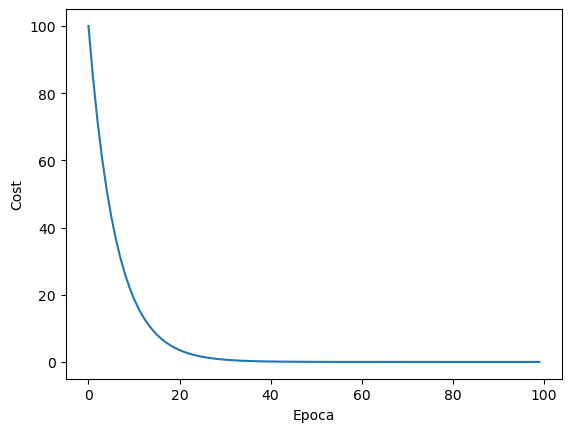

In [41]:
plt.plot(losses)
plt.xlabel('Epoca')
plt.ylabel('Cost')
plt.show()

## Optimizatori Pytorch

Mai sus s-a implementat in mod manual algoritmul de SGD, doar pentru a demonstra calculul gradientilor si efectul asupra ponderilor. De regula, se foloseste un agloritm de optimizare predefinit care aplica gradientii pe ponderi. O lista a optimizatorilor implementati in Pytorch este data mai jos.

In [42]:
import torch.optim as optim
[opt for opt in dir(optim) if opt[0].isupper()]

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam']

Fiecare optimizator preia o lista de parametri (de ex ponderile unui model de predictie). Dupa ce gradientii pentru minibatchul curent sunt calculati, se aplica in mod corespunzator pe ponderi. 

In [43]:
x = torch.tensor(20.0)
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-3
optimizer = optim.SGD([params], lr=learning_rate)

Secventa care urmeaza are acelasi scop ca si ciclarea din sectiunea anterioara: se modifica ponderile pentru a face minimizarea functiei `error`.

In [44]:
losses = []

for epoch in range(1, n_iters + 1):
    y_hat = model(x, *params)
    loss = error(y_hat, y_true, params[1:],  lmbda)
    losses.append(loss.item())
    print(f'Iteration: {epoch}, loss: {loss}')
    # se pun gradientii anterior calculati pe 0. Intrucat optimizatorul este responsabil cu 
    # managementul ponderilor, resetarea gradientilor este facuta prin intermediul lui
    optimizer.zero_grad()
    
    # calcul de derivate partiale
    loss.backward()  
    
    # se modifica ponderile folosind gradientii calculati de apelul backward()
    optimizer.step()

Iteration: 1, loss: 100.0
Iteration: 2, loss: 3.9207983016967773
Iteration: 3, loss: 0.15429987013339996
Iteration: 4, loss: 0.006642207968980074
Iteration: 5, loss: 0.0008512443164363503
Iteration: 6, loss: 0.000621881103143096
Iteration: 7, loss: 0.0006105515058152378
Iteration: 8, loss: 0.000607771216891706
Iteration: 9, loss: 0.0006053348770365119
Iteration: 10, loss: 0.0006029214127920568
Iteration: 11, loss: 0.0006005181348882616
Iteration: 12, loss: 0.000598124461248517
Iteration: 13, loss: 0.0005957404500804842
Iteration: 14, loss: 0.0005933656939305365
Iteration: 15, loss: 0.0005910006002523005
Iteration: 16, loss: 0.0005886448197998106
Iteration: 17, loss: 0.0005862982361577451
Iteration: 18, loss: 0.0005839611985720694
Iteration: 19, loss: 0.0005816334742121398
Iteration: 20, loss: 0.0005793151794932783
Iteration: 21, loss: 0.0005770060233771801
Iteration: 22, loss: 0.0005747061804868281
Iteration: 23, loss: 0.0005724154179915786
Iteration: 24, loss: 0.0005701337940990925
It

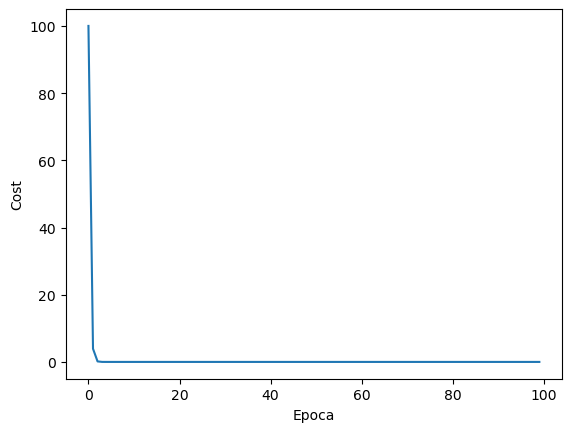

In [45]:
plt.plot(losses)
plt.xlabel('Epoca')
plt.ylabel('Cost')
plt.show()